In [1]:
import tensorflow
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
import patoolib

In [3]:
patoolib.extract_archive("puc_data_segmented.tar",outdir="Untitled Folder 1")

patool: Extracting puc_data_segmented.tar ...
patool: running /bin/tar --extract --file puc_data_segmented.tar --directory "Untitled Folder 1"
patool: ... puc_data_segmented.tar extracted to `Untitled Folder 1'.


'Untitled Folder 1'

In [4]:
os.listdir("./Untitled Folder 1/puc_data_segmented/train")

['empty', 'occupied']

In [5]:
path1='./Untitled Folder 1/puc_data_segmented/train'

In [6]:
os.listdir(path1)

['empty', 'occupied']

In [7]:
k=0
for i in os.listdir(path1):
    if i.endswith('.jpg')==True:
        path2=path1+'/'+i
        print('#'*100)
        
        
        a=cv2.imread(path2)
        print(a)
        cv2.imshow(path2,a)
        print(path2)
        break
            
        k+=1
        print(str(k)*100)

In [8]:
import numpy
import os
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [9]:
files_train = 0
files_validation = 0

cwd = os.getcwd()
folder = './Untitled Folder 1/puc_data_segmented/train'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_train += len(files)


folder = './Untitled Folder 1/puc_data_segmented/test'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_validation += len(files)

print(files_train,files_validation)

9407 4407


In [10]:
img_width, img_height = 48, 48
train_data_dir = "./Untitled Folder 1/puc_data_segmented/train"
validation_data_dir = "./Untitled Folder 1/puc_data_segmented/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 70
epochs = 6
num_classes = 2

In [11]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:10]:
    layer.trainable = False

In [12]:
x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
#x = Dense(256, activation="relu")(x)
#x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model
model_final = Model(input = model.input, output = predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), 
                    metrics=["accuracy"]) # See learning rate is very low

/home/chiranjeev/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


In [13]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 9407 images belonging to 2 classes.
Found 4407 images belonging to 2 classes.


In [14]:
# Save the model according to the conditions
checkpoint = ModelCheckpoint("car1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [15]:
### Start training!

history_object = model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early])


/home/chiranjeev/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/home/chiranjeev/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_steps=4407, steps_per_epoch=134, validation_data=<keras_pre..., epochs=6, callbacks=[<keras.ca...)`
  if __name__ == '__main__':


Epoch 1/6
134/134 [==============================] - 3838s 29s/step - loss: 0.5501 - acc: 0.7233 - val_loss: 0.3544 - val_acc: 0.9560

Epoch 00001: val_acc improved from -inf to 0.95603, saving model to car1.h5
Epoch 2/6
134/134 [==============================] - 3837s 29s/step - loss: 0.3126 - acc: 0.9076 - val_loss: 0.1974 - val_acc: 0.9805

Epoch 00002: val_acc improved from 0.95603 to 0.98045, saving model to car1.h5
Epoch 3/6
134/134 [==============================] - 3841s 29s/step - loss: 0.1924 - acc: 0.9552 - val_loss: 0.1153 - val_acc: 0.9869

Epoch 00003: val_acc improved from 0.98045 to 0.98691, saving model to car1.h5
Epoch 4/6
134/134 [==============================] - 3840s 29s/step - loss: 0.1260 - acc: 0.9711 - val_loss: 0.0758 - val_acc: 0.9896

Epoch 00004: val_acc improved from 0.98691 to 0.98963, saving model to car1.h5
Epoch 5/6
134/134 [==============================] - 3835s 29s/step - loss: 0.0897 - acc: 0.9797 - val_loss: 0.0545 - val_acc: 0.9914

Epoch 00005:

In [16]:
model_final.save("park1.model")

dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])


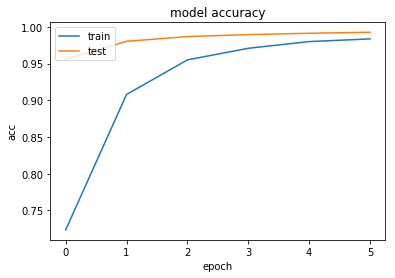

In [17]:
import matplotlib.pyplot as plt
print(history_object.history.keys())
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

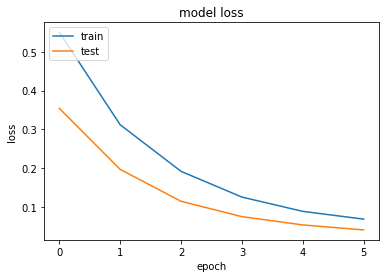

In [18]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

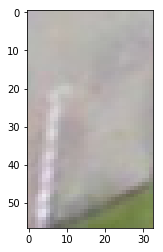

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
img=mpimg.imread('empty01.jpg')
plt.imshow(img)

In [20]:
import tensorflow as tf
def prepare(filepath):
    img_size=48
    img_array=cv2.imread(filepath,cv2.IMREAD_COLOR)
    new_array=cv2.resize(img_array,(img_size,img_size))
    return new_array.reshape(-1,img_size,img_size,3)

model=tf.keras.models.load_model("park1.model")
prediction=model.predict([prepare('occupied.jpg')])
prediction1=model.predict([prepare('empty01.jpg')])

In [21]:
prediction1

array([[1.0000000e+00, 5.4801973e-08]], dtype=float32)

In [22]:
prediction

array([[0., 1.]], dtype=float32)